## Many To Many 실행 결과, 앞의 추이를 그대로 따라가는것으로 보임

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, TimeDistributed, Dropout


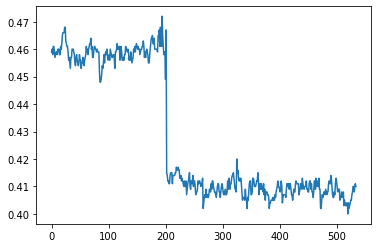

In [ ]:
df=pd.read_csv('m2_s2_bank_959c290884d3c44d85ccdf05a2bf52e1__site_0d39d11b52565146a236a646d49133f4.csv')
df=df[df['CellNo']==1].reset_index(drop=True)
df=df['ResistValue']
df.plot()

In [ ]:
def error_rate(original, prediction, ft_len, forecast_len):
    error_avg = []
    ft_len = ft_len-1
    for i in range(forecast_len):
      error = abs((original[ft_len+i] - prediction[-forecast_len+i]))/original[ft_len+i] * 100
      print('num',i,error,'actual',original[ft_len+i],'prediction',predictions[-forecast_len+i])
      print("오차율 :",error)
      error_avg.append(error)
    print('최소 오류값 :',min(error_avg))
    print('최대 오류값 :',max(error_avg))
    return sum(error_avg)/len(error_avg)

In [ ]:
def make_dataset(xData, step):
    
    m = len(xData)-step-1
    x, y =[], []
    for i in range(m):
      a = xData[i:(i+step)]
      x.append(a)
    xBatch = np.reshape(np.array(x), (m,step,1))

    for i in range(m):
      a = xData[(i+step):(i+step+20)]
      y.append(a[-1])
    yBatch = np.reshape(np.array(y), (m,1))

    return xBatch, yBatch

In [ ]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P
# Initialization for system model.
A = 1
H = 1
Q = 0.0001
R = 0.001
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

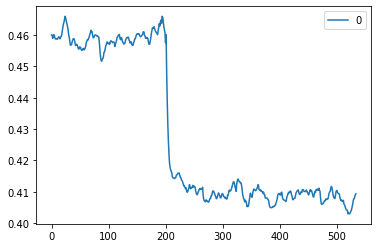

In [ ]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save
tt=pd.DataFrame(df)
tt.plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

train=df_scaled
feature_cols = ['ResistValue']
label_cols = ['ResistValue']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature=train_feature.values

In [ ]:
train_feature, train_label = make_dataset(train_feature, 20)
total_len = len(train_feature)
print(train_label.shape)
x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

(514, 1)


In [ ]:
model= Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), 
               activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(Dropout(0.3))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 20, 64)            8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 64)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 20, 32)            2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 32)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 20, 1)             3

In [ ]:
from keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop=EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, epochs=100, batch_size=1)
model.save("LSTM_0716_Dropout(0.3)_v2.h5")

Epoch 1/100
411/411 [==============================] - 23s 4ms/step - loss: 0.0689 - mse: 0.0689
Epoch 2/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0502 - mse: 0.0502
Epoch 3/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0459 - mse: 0.0459
Epoch 4/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0422 - mse: 0.0422
Epoch 5/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0429 - mse: 0.0429
Epoch 6/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0503 - mse: 0.0503
Epoch 7/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0398 - mse: 0.0398
Epoch 8/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0502 - mse: 0.0502
Epoch 9/100
411/411 [==============================] - 2s 5ms/step - loss: 0.0378 - mse: 0.0378
Epoch 10/100
411/411 [==============================] - 2s 4ms/step - loss: 0.0403 - mse: 0.0403
Epoch 11/100
411/411 [================

In [ ]:
model = load_model('manyTomany_1000.h5')

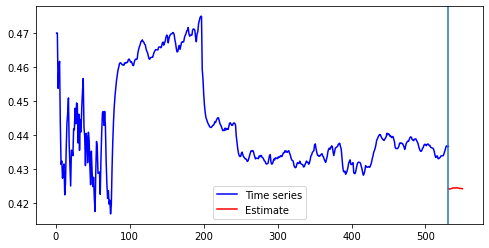

In [ ]:
df=pd.read_csv('m2_s2_bank_959c290884d3c44d85ccdf05a2bf52e1__site_0d39d11b52565146a236a646d49133f4.csv')
df=df[df['CellNo']==44].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

# 칼만필터 적용
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti
x_test2 = r_esti_save

# Scaling
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
df_scaled = scaler.fit_transform(x_test2[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# 예측 출력
nFuture = 20
lastData = np.copy(df_scaled)
dataset = lastData[-40:-20].reshape(1,20,1) 
estimate=[]

for i in range(nFuture):
  # 가장 마지막 데이터 가져오기
  dataset = dataset[-20:].reshape(1,20,1)
  # Dataset에 대한 예측
  day=0
  yHat = model.predict(dataset)[0][day]
  yHat = yHat.reshape(1,-1)
  yHat = scaler.inverse_transform(yHat)
  # 1일 후 데이터를 예측데이터에 추가
  estimate.append(yHat[0])
  tmp=dataset.flatten()

  tmp = np.append(tmp,yHat[0])
  #dataset = np.insert(dataset[0], len(dataset), yHat)
  dataset=tmp

ax1 = np.arange(1,len(x_test2)+1)
ax2 = np.arange(len(x_test2), len(x_test2)+20)
plt.figure(figsize=(8, 4))
plt.plot(ax1, x_test2,  color='blue',  label='Time series' )
plt.plot(ax2, estimate,  color='red',  label='Estimate')
plt.axvline(x=ax1[-1])
plt.legend()
plt.show()

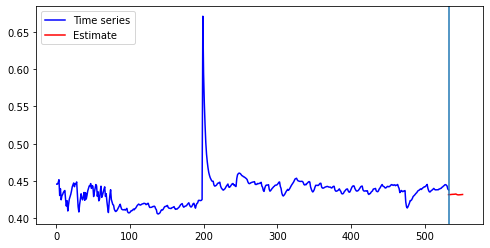

In [ ]:
df=pd.read_csv('m2_s2_bank_959c290884d3c44d85ccdf05a2bf52e1__site_0d39d11b52565146a236a646d49133f4.csv')
df=df[df['CellNo']==65].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

# 칼만필터 적용
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti
x_test2 = r_esti_save

# Scaling
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
df_scaled = scaler.fit_transform(x_test2[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# 예측 출력
nFuture = 20
lastData = np.copy(df_scaled)
dataset = lastData[-40:-20].reshape(1,20,1) 
estimate=[]

for i in range(nFuture):
  # 가장 마지막 데이터 가져오기
  dataset = dataset[-20:].reshape(1,20,1)
  # Dataset에 대한 예측
  day=0
  yHat = model.predict(dataset)[0][day]
  yHat = yHat.reshape(1,-1)
  yHat = scaler.inverse_transform(yHat)
  # 1일 후 데이터를 예측데이터에 추가
  estimate.append(yHat[0])
  tmp=dataset.flatten()

  tmp = np.append(tmp,yHat[0])
  #dataset = np.insert(dataset[0], len(dataset), yHat)
  dataset=tmp

ax1 = np.arange(1,len(x_test2)+1)
ax2 = np.arange(len(x_test2), len(x_test2)+20)
plt.figure(figsize=(8, 4))
plt.plot(ax1, x_test2,  color='blue',  label='Time series' )
plt.plot(ax2, estimate,  color='red',  label='Estimate')
plt.axvline(x=ax1[-1])
plt.legend()
plt.show()

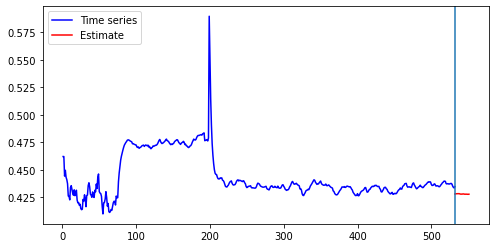

In [ ]:
df=pd.read_csv('m2_s2_bank_959c290884d3c44d85ccdf05a2bf52e1__site_0d39d11b52565146a236a646d49133f4.csv')
df=df[df['CellNo']==78].reset_index(drop=True)
x_test2=df['ResistValue']
n_samples=len(x_test2)
x_0 = x_test2[1]

# 칼만필터 적용
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti
x_test2 = r_esti_save

# Scaling
scaler = MinMaxScaler()
scale_cols = ['ResistValue']
x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
df_scaled = scaler.fit_transform(x_test2[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

# 예측 출력
nFuture = 20
lastData = np.copy(df_scaled)
dataset = lastData[-40:-20].reshape(1,20,1) 
estimate=[]

for i in range(nFuture):
  # 가장 마지막 데이터 가져오기
  dataset = dataset[-20:].reshape(1,20,1)
  # Dataset에 대한 예측
  day=0
  yHat = model.predict(dataset)[0][day]
  yHat = yHat.reshape(1,-1)
  yHat = scaler.inverse_transform(yHat)
  # 1일 후 데이터를 예측데이터에 추가
  estimate.append(yHat[0])
  tmp=dataset.flatten()

  tmp = np.append(tmp,yHat[0])
  #dataset = np.insert(dataset[0], len(dataset), yHat)
  dataset=tmp

ax1 = np.arange(1,len(x_test2)+1)
ax2 = np.arange(len(x_test2), len(x_test2)+20)
plt.figure(figsize=(8, 4))
plt.plot(ax1, x_test2,  color='blue',  label='Time series' )
plt.plot(ax2, estimate,  color='red',  label='Estimate')
plt.axvline(x=ax1[-1])
plt.legend()
plt.show()